# Training the Wave Decomposition Head

This notebook trains a neural network to predict probabilistic wave decomposition for the ARZ traffic flow model.

In [1]:
import sys
import os

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running in Colab - using inline module definitions")
    COLAB_INLINE = True
else:
    sys.path.insert(0, "/Users/katiewang/saint-venant")
    COLAB_INLINE = False

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
try:
    from tqdm.notebook import tqdm
except:
    from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Running in Colab - using inline module definitions
Using device: cuda


In [ ]:
if not IN_COLAB or not COLAB_INLINE:
    from arz_solver import ARZConfig, run, initial_condition_from_steps
    from arz_solver.nn_wave_head import (
        WaveDecompositionHead,
        WaveDecompositionLoss,
        compute_shock_intensity,
        compute_filtered_shock_score,
        compute_eigenvectors_torch,
    )
else:
    from dataclasses import dataclass
    from typing import Optional, Tuple, Callable, List, Dict
    
    # --- ARZConfig ---
    @dataclass
    class ARZConfig:
        nx: int = 200
        L: float = 1.0
        T: float = 1.0
        gamma: float = 1.0
        cfl_factor: float = 0.1
        bc_left: Optional[Tuple[float, float]] = (0.5, 1.0)
        bc_right: Optional[Tuple[float, float]] = (0.3, 0.5)
        bc_left_time: Optional[Callable[[float], Tuple[float, float]]] = None

        def __post_init__(self):
            self.x = np.linspace(0, self.L, self.nx)
            self.dx = self.x[1] - self.x[0]
            self.dt = self.cfl_factor * self.dx
            self.nt = int(self.T / self.dt)

    def pressure(rho, gamma):
        return np.power(rho, gamma)

    def dp_drho(rho, gamma):
        if gamma == 1.0:
            return np.full_like(rho, gamma)
        return gamma * np.power(rho, gamma - 1)

    def rusanov_flux(uL, uR, gamma, eps=1e-10):
        rhoL, rho_wL = uL[0], uL[1]
        rhoR, rho_wR = uR[0], uR[1]
        wL = rho_wL / rhoL if rhoL > eps else 0.0
        wR = rho_wR / rhoR if rhoR > eps else 0.0
        vL = wL - pressure(np.array([rhoL]), gamma)[0]
        vR = wR - pressure(np.array([rhoR]), gamma)[0]
        fL = np.array([rhoL * vL, rho_wL * vL])
        fR = np.array([rhoR * vR, rho_wR * vR])
        sL = max(abs(vL), abs(vL - rhoL * dp_drho(np.array([rhoL]), gamma)[0]))
        sR = max(abs(vR), abs(vR - rhoR * dp_drho(np.array([rhoR]), gamma)[0]))
        smax = max(sL, sR)
        return 0.5 * (fL + fR) - 0.5 * smax * (uR - uL)

    def hll_flux(uL, uR, gamma, eps=1e-10):
        """HLL flux - less diffusive than Rusanov."""
        rhoL, rho_wL = uL[0], uL[1]
        rhoR, rho_wR = uR[0], uR[1]
        wL = rho_wL / rhoL if rhoL > eps else 0.0
        wR = rho_wR / rhoR if rhoR > eps else 0.0
        vL = wL - pressure(np.array([rhoL]), gamma)[0]
        vR = wR - pressure(np.array([rhoR]), gamma)[0]
        
        fL = np.array([rhoL * vL, rho_wL * vL])
        fR = np.array([rhoR * vR, rho_wR * vR])
        
        lam1L, lam2L = vL, vL - rhoL * gamma * (rhoL ** (gamma - 1))
        lam1R, lam2R = vR, vR - rhoR * gamma * (rhoR ** (gamma - 1))
        
        sL = min(lam1L, lam2L, lam1R, lam2R)
        sR = max(lam1L, lam2L, lam1R, lam2R)
        
        if sL >= 0:
            return fL
        elif sR <= 0:
            return fR
        else:
            return (sR * fL - sL * fR + sL * sR * (uR - uL)) / (sR - sL)
    def _weno5_reconstruct(v):
        eps_w = 1e-6
        N = len(v)
        n_ifaces = N - 4
        v_minus = np.zeros(n_ifaces)
        v_plus = np.zeros(n_ifaces)
        for j in range(n_ifaces):
            i = j + 2
            q0 = (1/3)*v[i-2] - (7/6)*v[i-1] + (11/6)*v[i]
            q1 = -(1/6)*v[i-1] + (5/6)*v[i] + (1/3)*v[i+1]
            q2 = (1/3)*v[i] + (5/6)*v[i+1] - (1/6)*v[i+2]
            b0 = (13/12)*(v[i-2]-2*v[i-1]+v[i])**2 + (1/4)*(v[i-2]-4*v[i-1]+3*v[i])**2
            b1 = (13/12)*(v[i-1]-2*v[i]+v[i+1])**2 + (1/4)*(v[i-1]-v[i+1])**2
            b2 = (13/12)*(v[i]-2*v[i+1]+v[i+2])**2 + (1/4)*(3*v[i]-4*v[i+1]+v[i+2])**2
            w0 = 0.1/(eps_w+b0)**2; w1 = 0.6/(eps_w+b1)**2; w2 = 0.3/(eps_w+b2)**2
            ws = w0+w1+w2
            v_minus[j] = (w0*q0+w1*q1+w2*q2)/ws
            q0r = (1/3)*v[i+3]-(7/6)*v[i+2]+(11/6)*v[i+1] if i+3<N else v[i+1]
            q1r = -(1/6)*v[i+2]+(5/6)*v[i+1]+(1/3)*v[i]
            q2r = (1/3)*v[i+1]+(5/6)*v[i]-(1/6)*v[i-1]
            b0r = (13/12)*(v[i+3]-2*v[i+2]+v[i+1])**2+(1/4)*(v[i+3]-4*v[i+2]+3*v[i+1])**2 if i+3<N else b2
            b1r = (13/12)*(v[i+2]-2*v[i+1]+v[i])**2+(1/4)*(v[i+2]-v[i])**2
            b2r = (13/12)*(v[i+1]-2*v[i]+v[i-1])**2+(1/4)*(3*v[i+1]-4*v[i]+v[i-1])**2
            w0r = 0.1/(eps_w+b0r)**2; w1r = 0.6/(eps_w+b1r)**2; w2r = 0.3/(eps_w+b2r)**2
            wsr = w0r+w1r+w2r
            v_plus[j] = (w0r*q0r+w1r*q1r+w2r*q2r)/wsr
        return v_minus, v_plus

    def run(rho0, w0, config, bc_type="zero_gradient", reconstruction="constant", **kwargs):
        nx, nt = config.nx, config.nt
        dx, dt, gamma = config.dx, config.dt, config.gamma
        eps = 1e-12
        use_weno = reconstruction == "weno5"
        rho = rho0.copy()
        rho_w = rho * w0.copy()
        rho_history = np.zeros((nt + 1, nx))
        w_history = np.zeros((nt + 1, nx))
        v_history = np.zeros((nt + 1, nx))
        rho_history[0] = rho
        w_history[0] = rho_w / (rho + eps)
        v_history[0] = w_history[0] - pressure(rho, gamma)

        def _rhs(rho_loc, rho_w_loc):
            if use_weno:
                rho_g = np.concatenate([rho_loc[:3][::-1], rho_loc, rho_loc[-3:][::-1]])
                rho_w_g = np.concatenate([rho_w_loc[:3][::-1], rho_w_loc, rho_w_loc[-3:][::-1]])
                rL, rR = _weno5_reconstruct(rho_g)
                rwL, rwR = _weno5_reconstruct(rho_w_g)
                ni = len(rL)
                fl = np.zeros((ni, 2))
                for i in range(ni):
                    fl[i] = hll_flux(np.array([rL[i], rwL[i]]), np.array([rR[i], rwR[i]]), gamma)
                fl = fl[:nx+1]
            else:
                rho_g = np.concatenate([[rho_loc[0]], rho_loc, [rho_loc[-1]]])
                rho_w_g = np.concatenate([[rho_w_loc[0]], rho_w_loc, [rho_w_loc[-1]]])
                fl = np.zeros((nx + 1, 2))
                for i in range(nx + 1):
                    fl[i] = hll_flux(np.array([rho_g[i], rho_w_g[i]]), np.array([rho_g[i+1], rho_w_g[i+1]]), gamma)
            return -(1/dx)*(fl[1:,0]-fl[:-1,0]), -(1/dx)*(fl[1:,1]-fl[:-1,1])

        for n in range(nt):
            if use_weno:
                k1r, k1w = _rhs(rho, rho_w)
                r1 = np.maximum(rho + dt*k1r, 0); w1 = rho_w + dt*k1w
                k2r, k2w = _rhs(r1, w1)
                r2 = np.maximum(0.75*rho + 0.25*(r1+dt*k2r), 0); w2 = 0.75*rho_w + 0.25*(w1+dt*k2w)
                k3r, k3w = _rhs(r2, w2)
                rho = np.maximum((1/3)*rho + (2/3)*(r2+dt*k3r), 0)
                rho_w = (1/3)*rho_w + (2/3)*(w2+dt*k3w)
            else:
                k1r, k1w = _rhs(rho, rho_w)
                rho = np.maximum(rho + dt*k1r, 0)
                rho_w = rho_w + dt*k1w
            w = rho_w / (rho + eps)
            v = w - pressure(rho, gamma)
            rho_history[n + 1] = rho
            w_history[n + 1] = w
            v_history[n + 1] = v
        return rho_history, w_history, v_history

    def initial_condition_from_steps(x, rho_steps, v_steps=None, default_v=0.1, gamma=1.0):
        steps = sorted(rho_steps, key=lambda p: p[0])
        rho0 = np.full_like(x, steps[-1][1], dtype=float)
        for i in range(len(steps) - 2, -1, -1):
            x_end, val = steps[i]
            rho0[x < x_end] = val
        v0 = np.full_like(x, default_v) if v_steps is None else np.full_like(x, default_v)
        w0 = v0 + pressure(rho0, gamma)
        return rho0, w0

    class WaveDecompositionHead(nn.Module):
        def __init__(self, state_dim=2, n_waves=2, hidden_dim=64, n_layers=3, gamma=1.0):
            super().__init__()
            self.state_dim = state_dim
            self.n_waves = n_waves
            self.gamma = gamma
            input_dim = 4 * state_dim
            
            layers = [nn.Linear(input_dim, hidden_dim), nn.ReLU()]
            for _ in range(n_layers - 1):
                layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.ReLU()])
            self.wave_encoder = nn.Sequential(*layers)
            self.head_p = nn.Linear(hidden_dim, n_waves)
            self.head_alpha = nn.Linear(hidden_dim, n_waves)
            
            shock_layers = [nn.Linear(input_dim, hidden_dim), nn.ReLU()]
            for _ in range(n_layers - 1):
                shock_layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.ReLU()])
            self.shock_encoder = nn.Sequential(*shock_layers)
            self.head_q = nn.Linear(hidden_dim, n_waves)

        def forward(self, U_L, U_center, U_R):
            dU = U_R - U_L
            x = torch.cat([U_L, U_center, U_R, dU], dim=-1)
            
            h_wave = self.wave_encoder(x)
            p = torch.sigmoid(self.head_p(h_wave))
            alpha = self.head_alpha(h_wave)
            
            h_shock = self.shock_encoder(x)
            q = torch.sigmoid(self.head_q(h_shock))
            
            return {"p": p, "alpha": alpha, "q": q}

    def compute_eigenvectors_torch(rho, w, gamma, eps=1e-12):
        rho_safe = torch.clamp(rho, min=eps)
        p_rho = rho_safe ** gamma
        pp_rho = gamma * rho_safe ** (gamma - 1) if gamma != 1.0 else torch.ones_like(rho_safe) * gamma
        v = w - p_rho
        
        lam1 = v - rho_safe * pp_rho
        lam2 = v
        eigenvalues = torch.stack([lam1, lam2], dim=-1)
        
        batch = rho.shape[0]
        R = torch.zeros(batch, 2, 2, device=rho.device, dtype=rho.dtype)
        R[:, 0, 0] = 1.0
        R[:, 1, 0] = w - rho_safe * pp_rho
        R[:, 0, 1] = 0.0
        R[:, 1, 1] = 1.0
        
        return eigenvalues, R

    class WaveDecompositionLoss(nn.Module):
        def __init__(self, lambda_wave=1.0, lambda_shock=1.0):
            super().__init__()
            self.lambda_wave = lambda_wave
            self.lambda_shock = lambda_shock

        def forward(self, pred, U_L, U_R, gamma):
            p, alpha, q = pred["p"], pred["alpha"], pred["q"]
            delta_U = U_R - U_L
            eps = 1e-12
            
            rho_L = torch.clamp(U_L[:, 0], min=eps)
            rho_R = torch.clamp(U_R[:, 0], min=eps)
            rho_w_L, rho_w_R = U_L[:, 1], U_R[:, 1]
            w_L = rho_w_L / rho_L
            w_R = rho_w_R / rho_R
            rho_avg = 0.5 * (rho_L + rho_R)
            w_avg = 0.5 * (w_L + w_R)
            
            _, R = compute_eigenvectors_torch(rho_avg, w_avg, gamma, eps)
            
            reconstructed = torch.zeros_like(delta_U)
            for k in range(R.shape[1]):
                # p = wave activity probability, alpha = wave strength, r = direction of eigenvector, 
                # q = wave is shock vs rarefaction
                reconstructed += (p[:, k:k+1] * alpha[:, k:k+1]) * R[:, k, :]
            loss_wave = torch.mean((reconstructed - delta_U) ** 2)

            lam_L, _ = compute_eigenvectors_torch(rho_L, w_L, gamma, eps)
            lam_R, _ = compute_eigenvectors_torch(rho_R, w_R, gamma, eps)
            delta_lam = lam_R - lam_L
            y_shock = (delta_lam < 0).float()
            
            weight = torch.abs(delta_lam).detach()
            weight = weight / (weight.mean() + eps)
            loss_shock = nn.functional.binary_cross_entropy(q, y_shock, weight=weight)
            
            is_rarefaction = delta_lam > 0
            if is_rarefaction.any():
                loss_rarefaction = q[is_rarefaction].mean()
            else:
                loss_rarefaction = torch.tensor(0.0, device=q.device)
            loss_shock = loss_shock + 5.0 * loss_rarefaction

            loss_total = self.lambda_wave * loss_wave + self.lambda_shock * loss_shock
            return {"loss_total": loss_total, "loss_wave": loss_wave, "loss_shock": loss_shock, "y_shock": y_shock}

    def compute_shock_intensity(p, q, alpha):
        return torch.sum(p * q * torch.abs(alpha), dim=-1)

    def compute_filtered_shock_score(pred, U_L, U_R, gamma=1.0, eps=1e-12):
        p, q, alpha = pred["p"], pred["q"], pred["alpha"]
        rho_L = torch.clamp(U_L[:, 0], min=eps)
        w_L = U_L[:, 1] / rho_L
        rho_R = torch.clamp(U_R[:, 0], min=eps)
        w_R = U_R[:, 1] / rho_R
        lam_L, _ = compute_eigenvectors_torch(rho_L, w_L, gamma, eps)
        lam_R, _ = compute_eigenvectors_torch(rho_R, w_R, gamma, eps)
        delta_lam = lam_R - lam_L
        entropy_filter = (delta_lam < 0).float()
        raw = p * q * torch.abs(alpha)
        filtered = raw * entropy_filter
        return torch.sum(filtered, dim=-1)

    print("Inline ARZ modules loaded for Colab!")

Inline ARZ modules loaded for Colab!


In [4]:
def generate_data(sample_deltas, n_samples=50, n_queries=100, gamma=1.0, reconstruction="weno5"):
    U_L_list, U_center_list, U_R_list = [], [], []
    
    for _ in tqdm(range(n_samples), desc=f"Generating data ({reconstruction})"):
        config = ARZConfig(nx=200, T=1.0, gamma=gamma)
        
        n_regions = np.random.randint(2, 5)
        x_breaks = sorted(np.random.uniform(0.1, 0.9, n_regions - 1).tolist())
        x_breaks.append(1.1)
        
        rho_vals = np.random.uniform(0.1, 1.0, n_regions)
        rho_steps = list(zip(x_breaks, rho_vals))
        v0 = np.random.uniform(0.05, 0.3)
        
        rho0, w0 = initial_condition_from_steps(config.x, rho_steps, default_v=v0, gamma=gamma)
        rho_hist, w_hist, v_hist = run(rho0, w0, config, bc_type="zero_gradient", reconstruction=reconstruction)
        
        nt, nx = rho_hist.shape
        for _ in range(n_queries):
            t_idx = np.random.randint(1, nt)
            i = np.random.randint(2, nx - 2)
            for j in sample_deltas:
                if i - j in range(nx) and i + j in range(nx):
                    rho, w = rho_hist[t_idx], w_hist[t_idx]
                    U_L_list.append([rho[i-j], rho[i-j] * w[i-j]])
                    U_center_list.append([rho[i], rho[i] * w[i]])
                    U_R_list.append([rho[i+j], rho[i+j] * w[i+j]])
    
    return (
        torch.tensor(U_L_list, dtype=torch.float32),
        torch.tensor(U_center_list, dtype=torch.float32),
        torch.tensor(U_R_list, dtype=torch.float32),
    )

import os

gamma = 1.0
DATA_DIR = "/Users/katiewang/saint-venant/arz_solver/examples/data"
os.makedirs(DATA_DIR, exist_ok=True)
RECONSTRUCTION = "weno5"
WAVE_DATA_PATH = os.path.join(DATA_DIR, f"wave_head_data_{RECONSTRUCTION}.pt")
print(f"Data directory: {DATA_DIR}, reconstruction: {RECONSTRUCTION}")

if os.path.exists(WAVE_DATA_PATH):
    data = torch.load(WAVE_DATA_PATH, weights_only=True)
    U_L, U_center, U_R = data["U_L"], data["U_center"], data["U_R"]
    print(f"Loaded cached dataset from {WAVE_DATA_PATH}: {len(U_L)} samples")
else:
    U_L, U_center, U_R = generate_data(sample_deltas=[1, 2, 4], n_samples=50, n_queries=200, gamma=gamma, reconstruction=RECONSTRUCTION)
    torch.save({"U_L": U_L, "U_center": U_center, "U_R": U_R}, WAVE_DATA_PATH)
    print(f"Generated and saved dataset to {WAVE_DATA_PATH}: {len(U_L)} samples")

n_train = int(0.8 * len(U_L))
train_data = TensorDataset(U_L[:n_train], U_center[:n_train], U_R[:n_train])
test_data = TensorDataset(U_L[n_train:], U_center[n_train:], U_R[n_train:])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)

Data directory: /Users/katiewang/saint-venant/arz_solver/examples/data, reconstruction: weno5


Generating data (weno5):   0%|          | 0/50 [00:00<?, ?it/s]

Generated and saved dataset to /Users/katiewang/saint-venant/arz_solver/examples/data/wave_head_data_weno5.pt: 29807 samples


In [5]:
model = WaveDecompositionHead(state_dim=2, n_waves=2, hidden_dim=128, n_layers=4, gamma=gamma).to(device)
# loss_fn = WaveDecompositionLoss(lambda_wave=1.0, lambda_shock=5.0)
loss_fn = WaveDecompositionLoss(lambda_wave=1.0, lambda_shock=5.0)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 102,150


In [6]:
WAVE_HEAD_CKPT = os.path.join(DATA_DIR, "wave_head.pth")

if os.path.exists(WAVE_HEAD_CKPT):
    ckpt = torch.load(WAVE_HEAD_CKPT, map_location=device, weights_only=True)
    model.load_state_dict(ckpt["model_state"])
    train_losses = ckpt.get("train_losses", [])
    test_losses = ckpt.get("test_losses", [])
    train_wave_losses = ckpt.get("train_wave_losses", [])
    train_shock_losses = ckpt.get("train_shock_losses", [])
    print(f"Loaded wave head from {WAVE_HEAD_CKPT} ({len(train_losses)} epochs trained)")
    print("Skip the next cell (training) and go straight to evaluation or GNN.")
else:
    print(f"No checkpoint found at {WAVE_HEAD_CKPT}. Run training cell below.")

No checkpoint found at /Users/katiewang/saint-venant/arz_solver/examples/data/wave_head.pth. Run training cell below.


In [7]:
WAVE_HEAD_CKPT = os.path.join(DATA_DIR, "wave_head.pth")

n_epochs = 200
train_losses, test_losses = [], []
train_wave_losses, train_shock_losses = [], []

for epoch in tqdm(range(n_epochs), desc="Training"):
    model.train()
    epoch_total, epoch_wave, epoch_shock = 0, 0, 0
    for U_L_b, U_c_b, U_R_b in train_loader:
        U_L_b, U_c_b, U_R_b = U_L_b.to(device), U_c_b.to(device), U_R_b.to(device)
        optimizer.zero_grad()
        pred = model(U_L_b, U_c_b, U_R_b)
        losses = loss_fn(pred, U_L_b, U_R_b, gamma)
        losses["loss_total"].backward()
        optimizer.step()
        epoch_total += losses["loss_total"].item()
        epoch_wave += losses["loss_wave"].item()
        epoch_shock += losses["loss_shock"].item()
    n = len(train_loader)
    train_losses.append(epoch_total / n)
    train_wave_losses.append(epoch_wave / n)
    train_shock_losses.append(epoch_shock / n)
    
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for U_L_b, U_c_b, U_R_b in test_loader:
            U_L_b, U_c_b, U_R_b = U_L_b.to(device), U_c_b.to(device), U_R_b.to(device)
            pred = model(U_L_b, U_c_b, U_R_b)
            losses = loss_fn(pred, U_L_b, U_R_b, gamma)
            test_loss += losses["loss_total"].item()
    test_losses.append(test_loss / len(test_loader))
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}: total={train_losses[-1]:.4f} (wave={train_wave_losses[-1]:.4f}, shock={train_shock_losses[-1]:.4f}), test={test_losses[-1]:.4f}")

torch.save({
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
    "train_losses": train_losses,
    "test_losses": test_losses,
    "train_wave_losses": train_wave_losses,
    "train_shock_losses": train_shock_losses,
    "gamma": gamma,
}, WAVE_HEAD_CKPT)
print(f"Wave head saved to {WAVE_HEAD_CKPT}")

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 20: total=1.6526 (wave=0.0000, shock=0.3305), test=1.7954
Epoch 40: total=1.1370 (wave=0.0000, shock=0.2274), test=1.0894
Epoch 60: total=0.7154 (wave=0.0000, shock=0.1431), test=0.9194
Epoch 80: total=0.6335 (wave=0.0000, shock=0.1267), test=1.5952
Epoch 100: total=1.1444 (wave=0.0000, shock=0.2289), test=1.6097
Epoch 120: total=0.5064 (wave=0.0000, shock=0.1013), test=0.5531
Epoch 140: total=0.4119 (wave=0.0000, shock=0.0824), test=0.6139
Epoch 160: total=0.4702 (wave=0.0000, shock=0.0940), test=0.7663
Epoch 180: total=0.4376 (wave=0.0000, shock=0.0875), test=0.6174
Epoch 200: total=0.4499 (wave=0.0000, shock=0.0900), test=0.5941
Wave head saved to /Users/katiewang/saint-venant/arz_solver/examples/data/wave_head.pth


Shock accuracy: wave1=87.4%, wave2=76.9%


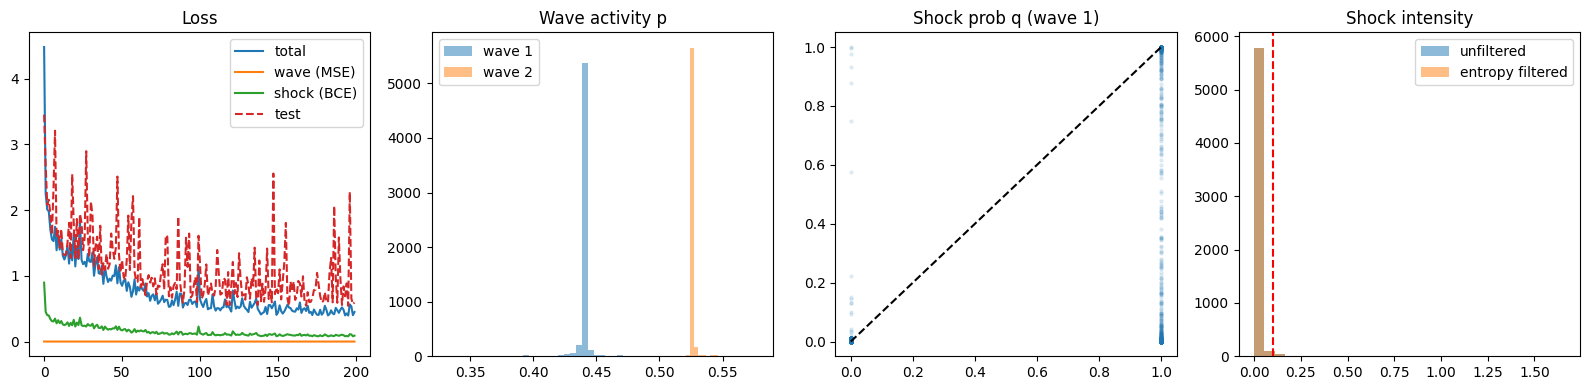

In [8]:
model.eval()
with torch.no_grad():
    # Get predictions on test set
    U_L_test = U_L[n_train:].to(device)
    U_c_test = U_center[n_train:].to(device)
    U_R_test = U_R[n_train:].to(device)
    
    pred = model(U_L_test, U_c_test, U_R_test)
    losses = loss_fn(pred, U_L_test, U_R_test, gamma)

p = pred["p"].cpu()
alpha = pred["alpha"].cpu()
q = pred["q"].cpu()
y_shock = losses["y_shock"].cpu()

acc1 = ((q[:, 0] > 0.5) == y_shock[:, 0]).float().mean()
acc2 = ((q[:, 1] > 0.5) == y_shock[:, 1]).float().mean()
print(f"Shock accuracy: wave1={acc1:.1%}, wave2={acc2:.1%}")

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].plot(train_losses, label="total")
axes[0].plot(train_wave_losses, label="wave (MSE)")
axes[0].plot(train_shock_losses, label="shock (BCE)")
axes[0].plot(test_losses, label="test", linestyle="--")
axes[0].legend()
axes[0].set_title("Loss")

axes[1].hist(p[:, 0].numpy(), bins=30, alpha=0.5, label="wave 1")
axes[1].hist(p[:, 1].numpy(), bins=30, alpha=0.5, label="wave 2")
axes[1].legend()
axes[1].set_title("Wave activity p")

axes[2].scatter(y_shock[:, 0], q[:, 0], alpha=0.1, s=5)
axes[2].plot([0, 1], [0, 1], "k--")
axes[2].set_title("Shock prob q (wave 1)")

s_raw = compute_shock_intensity(p, q, alpha)
s_filtered = compute_filtered_shock_score(pred, U_L_test, U_R_test, gamma).cpu()
axes[3].hist(s_raw.numpy(), bins=30, alpha=0.5, label="unfiltered")
axes[3].hist(s_filtered.numpy(), bins=30, alpha=0.5, label="entropy filtered")
axes[3].axvline(0.1, color="r", linestyle="--")
axes[3].legend()
axes[3].set_title("Shock intensity")

plt.tight_layout()
plt.show()

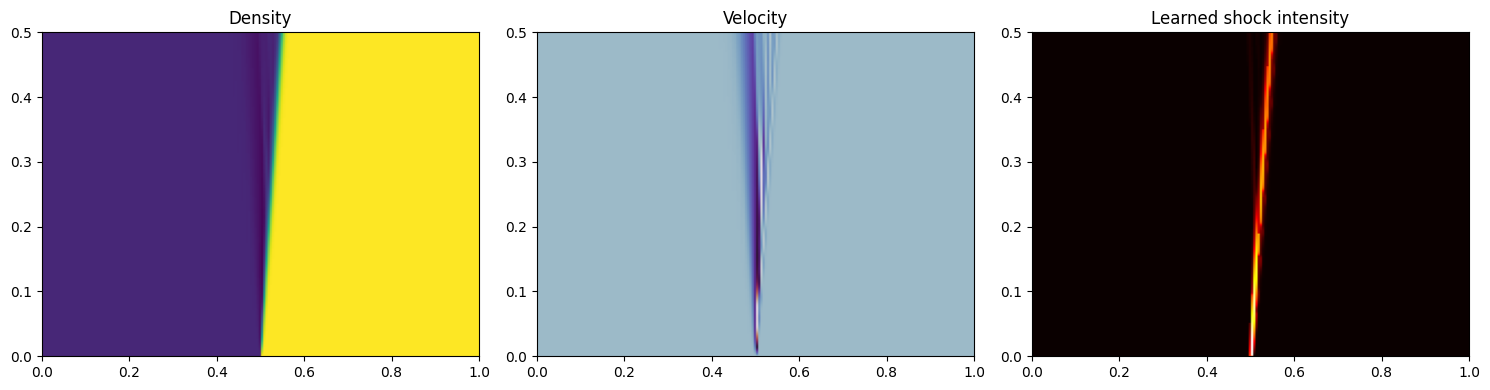

In [9]:
config = ARZConfig(nx=200, T=0.5, gamma=1.0)
rho0, w0 = initial_condition_from_steps(config.x, [(0.5, 0.2), (1.0, 0.8)], default_v=0.1)
rho_hist, w_hist, v_hist = run(rho0, w0, config, reconstruction=RECONSTRUCTION)

nt, nx = rho_hist.shape
shock_map = np.zeros((nt, nx - 2))

model.eval()
with torch.no_grad():
    for t_idx in range(nt):
        rho, w = rho_hist[t_idx], w_hist[t_idx]
        U_L_t = torch.tensor([[rho[i-1], rho[i-1]*w[i-1]] for i in range(1, nx-1)], dtype=torch.float32).to(device)
        U_c_t = torch.tensor([[rho[i], rho[i]*w[i]] for i in range(1, nx-1)], dtype=torch.float32).to(device)
        U_R_t = torch.tensor([[rho[i+1], rho[i+1]*w[i+1]] for i in range(1, nx-1)], dtype=torch.float32).to(device)
        
        pred = model(U_L_t, U_c_t, U_R_t)
        s = compute_filtered_shock_score(pred, U_L_t, U_R_t, gamma)
        shock_map[t_idx] = s.cpu().numpy()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
extent = [0, config.L, 0, config.T]

axes[0].imshow(rho_hist, aspect="auto", origin="lower", extent=extent)
axes[0].set_title("Density")

axes[1].imshow(v_hist, aspect="auto", origin="lower", extent=extent, cmap="twilight")
axes[1].set_title("Velocity")

axes[2].imshow(shock_map, aspect="auto", origin="lower", extent=extent, cmap="hot")
axes[2].set_title("Learned shock intensity")

plt.tight_layout()
plt.show()

Testing mesh invariance...


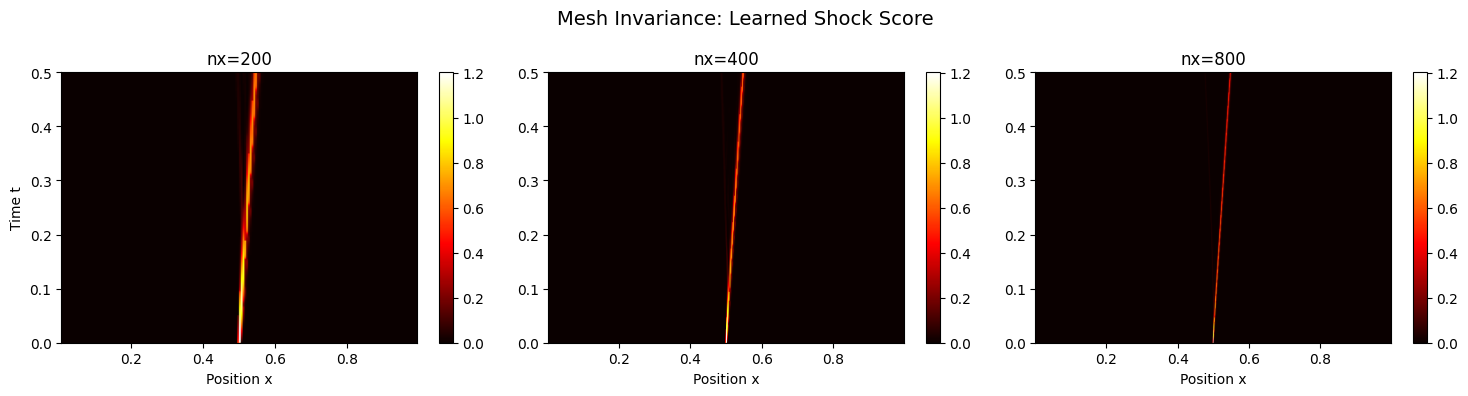

In [10]:
print("Testing mesh invariance...")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

model.eval()
for col, test_nx in enumerate([200, 400, 800]):
    config_test = ARZConfig(nx=test_nx, T=0.5, gamma=gamma)
    rho0, w0 = initial_condition_from_steps(config_test.x, [(0.5, 0.2), (1.0, 0.8)], default_v=0.1)
    rho_hist, w_hist, v_hist = run(rho0, w0, config_test, reconstruction=RECONSTRUCTION)
    
    nt, nx_grid = rho_hist.shape
    shock_map = np.zeros((nt, nx_grid - 2))
    
    with torch.no_grad():
        for t_idx in range(nt):
            rho, w = rho_hist[t_idx], w_hist[t_idx]
            U_L_t = torch.tensor([[rho[i-1], rho[i-1]*w[i-1]] for i in range(1, nx_grid-1)], dtype=torch.float32).to(device)
            U_c_t = torch.tensor([[rho[i], rho[i]*w[i]] for i in range(1, nx_grid-1)], dtype=torch.float32).to(device)
            U_R_t = torch.tensor([[rho[i+1], rho[i+1]*w[i+1]] for i in range(1, nx_grid-1)], dtype=torch.float32).to(device)
            
            pred = model(U_L_t, U_c_t, U_R_t)
            s = compute_filtered_shock_score(pred, U_L_t, U_R_t, gamma)
            shock_map[t_idx] = s.cpu().numpy()
    
    extent = [config_test.x[1], config_test.x[-2], 0, config_test.T]
    im = axes[col].imshow(shock_map, aspect="auto", origin="lower", extent=extent, cmap="hot")
    axes[col].set_title(f"nx={test_nx}")
    axes[col].set_xlabel("Position x")
    if col == 0:
        axes[col].set_ylabel("Time t")
    plt.colorbar(im, ax=axes[col])

plt.suptitle("Mesh Invariance: Learned Shock Score", fontsize=14)
plt.tight_layout()
plt.show()

Testing blur robustness (simulating neural operator diffusion)...


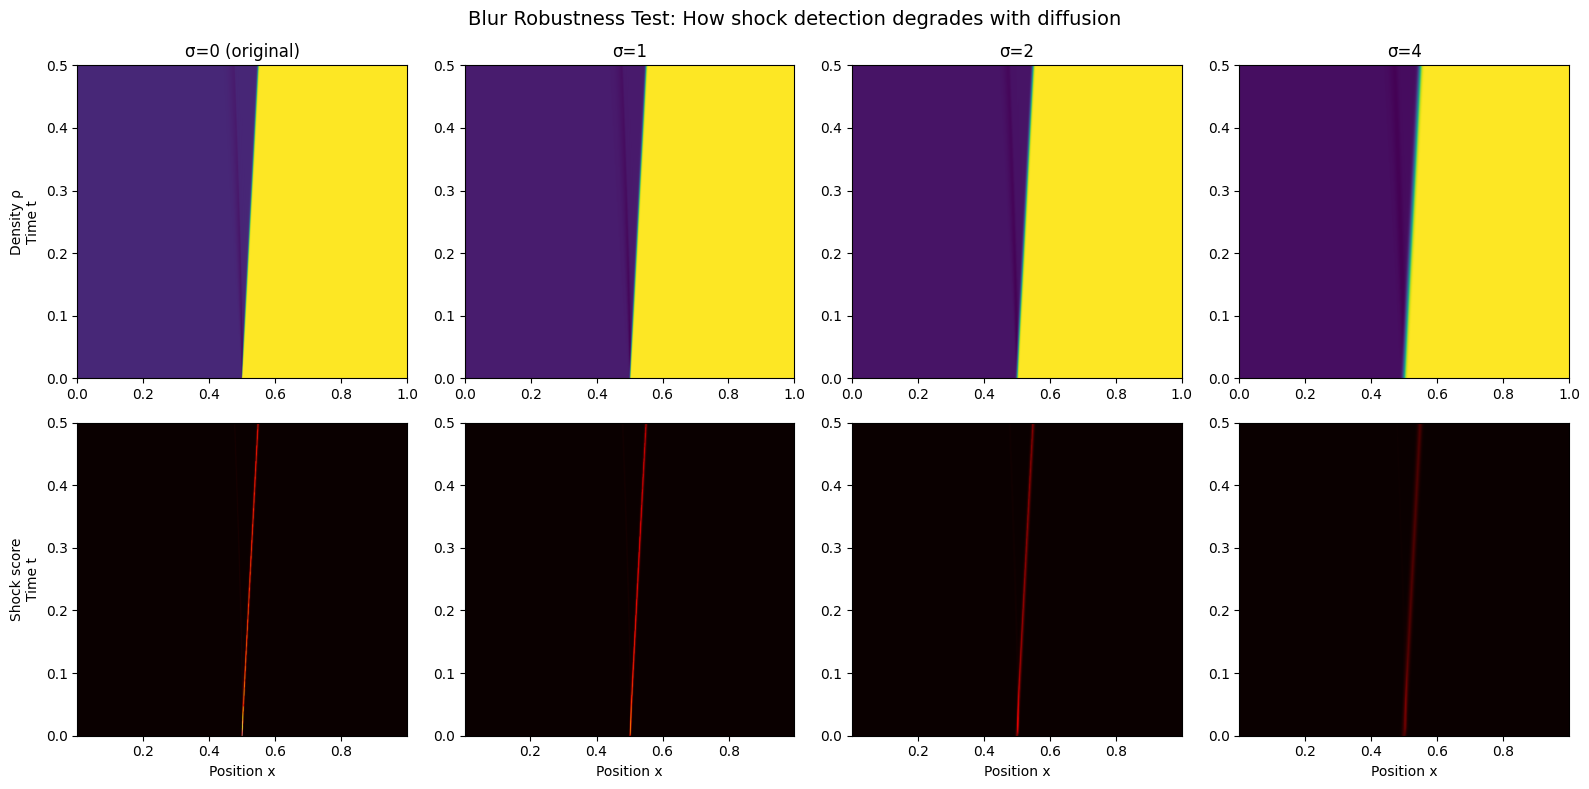


Peak shock scores by blur level:
  σ=0: max score = 1.202
  σ=1: max score = 0.755
  σ=2: max score = 0.442
  σ=4: max score = 0.212


In [11]:
from scipy.ndimage import gaussian_filter1d

print("Testing blur robustness (simulating neural operator diffusion)...")

config_blur = ARZConfig(nx=800, T=0.5, gamma=gamma)
rho0, w0 = initial_condition_from_steps(config_blur.x, [(0.5, 0.2), (1.0, 0.8)], default_v=0.1)
rho_hist_orig, w_hist_orig, v_hist_orig = run(rho0, w0, config_blur, reconstruction=RECONSTRUCTION)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
sigmas = [0, 1, 2, 4]

model.eval()
for col, sigma in enumerate(sigmas):
    if sigma == 0:
        rho_hist = rho_hist_orig.copy()
        w_hist = w_hist_orig.copy()
    else:
        rho_hist = gaussian_filter1d(rho_hist_orig, sigma=sigma, axis=1)
        w_hist = gaussian_filter1d(w_hist_orig, sigma=sigma, axis=1)
    
    nt, nx_grid = rho_hist.shape
    shock_map = np.zeros((nt, nx_grid - 2))
    
    with torch.no_grad():
        for t_idx in range(nt):
            rho, w = rho_hist[t_idx], w_hist[t_idx]
            U_L_t = torch.tensor([[rho[i-1], rho[i-1]*w[i-1]] for i in range(1, nx_grid-1)], dtype=torch.float32).to(device)
            U_c_t = torch.tensor([[rho[i], rho[i]*w[i]] for i in range(1, nx_grid-1)], dtype=torch.float32).to(device)
            U_R_t = torch.tensor([[rho[i+1], rho[i+1]*w[i+1]] for i in range(1, nx_grid-1)], dtype=torch.float32).to(device)
            
            pred = model(U_L_t, U_c_t, U_R_t)
            s = compute_filtered_shock_score(pred, U_L_t, U_R_t, gamma)
            shock_map[t_idx] = s.cpu().numpy()
    
    extent = [config_blur.x[1], config_blur.x[-2], 0, config_blur.T]
    extent_full = [config_blur.x[0], config_blur.x[-1], 0, config_blur.T]
    
    axes[0, col].imshow(rho_hist, aspect="auto", origin="lower", extent=extent_full, cmap="viridis")
    axes[0, col].set_title(f"σ={sigma}" + (" (original)" if sigma == 0 else ""))
    if col == 0:
        axes[0, col].set_ylabel("Density ρ\nTime t")
    
    im = axes[1, col].imshow(shock_map, aspect="auto", origin="lower", extent=extent, cmap="hot", vmin=0, vmax=shock_map.max() if sigma == 0 else axes[1, 0].images[0].get_clim()[1])
    if col == 0:
        axes[1, col].set_ylabel("Shock score\nTime t")
        vmax_ref = shock_map.max()
    axes[1, col].set_xlabel("Position x")

plt.suptitle("Blur Robustness Test: How shock detection degrades with diffusion", fontsize=14)
plt.tight_layout()
plt.show()

print("\nPeak shock scores by blur level:")
for col, sigma in enumerate(sigmas):
    if sigma == 0:
        rho_hist = rho_hist_orig.copy()
        w_hist = w_hist_orig.copy()
    else:
        rho_hist = gaussian_filter1d(rho_hist_orig, sigma=sigma, axis=1)
        w_hist = gaussian_filter1d(w_hist_orig, sigma=sigma, axis=1)
    
    nt, nx_grid = rho_hist.shape
    max_score = 0
    with torch.no_grad():
        for t_idx in range(nt):
            rho, w = rho_hist[t_idx], w_hist[t_idx]
            U_L_t = torch.tensor([[rho[i-1], rho[i-1]*w[i-1]] for i in range(1, nx_grid-1)], dtype=torch.float32).to(device)
            U_c_t = torch.tensor([[rho[i], rho[i]*w[i]] for i in range(1, nx_grid-1)], dtype=torch.float32).to(device)
            U_R_t = torch.tensor([[rho[i+1], rho[i+1]*w[i+1]] for i in range(1, nx_grid-1)], dtype=torch.float32).to(device)
            pred = model(U_L_t, U_c_t, U_R_t)
            s = compute_filtered_shock_score(pred, U_L_t, U_R_t, gamma)
            max_score = max(max_score, s.max().item())
    print(f"  σ={sigma}: max score = {max_score:.3f}")

Testing on Riemann problem with rarefaction + shock...


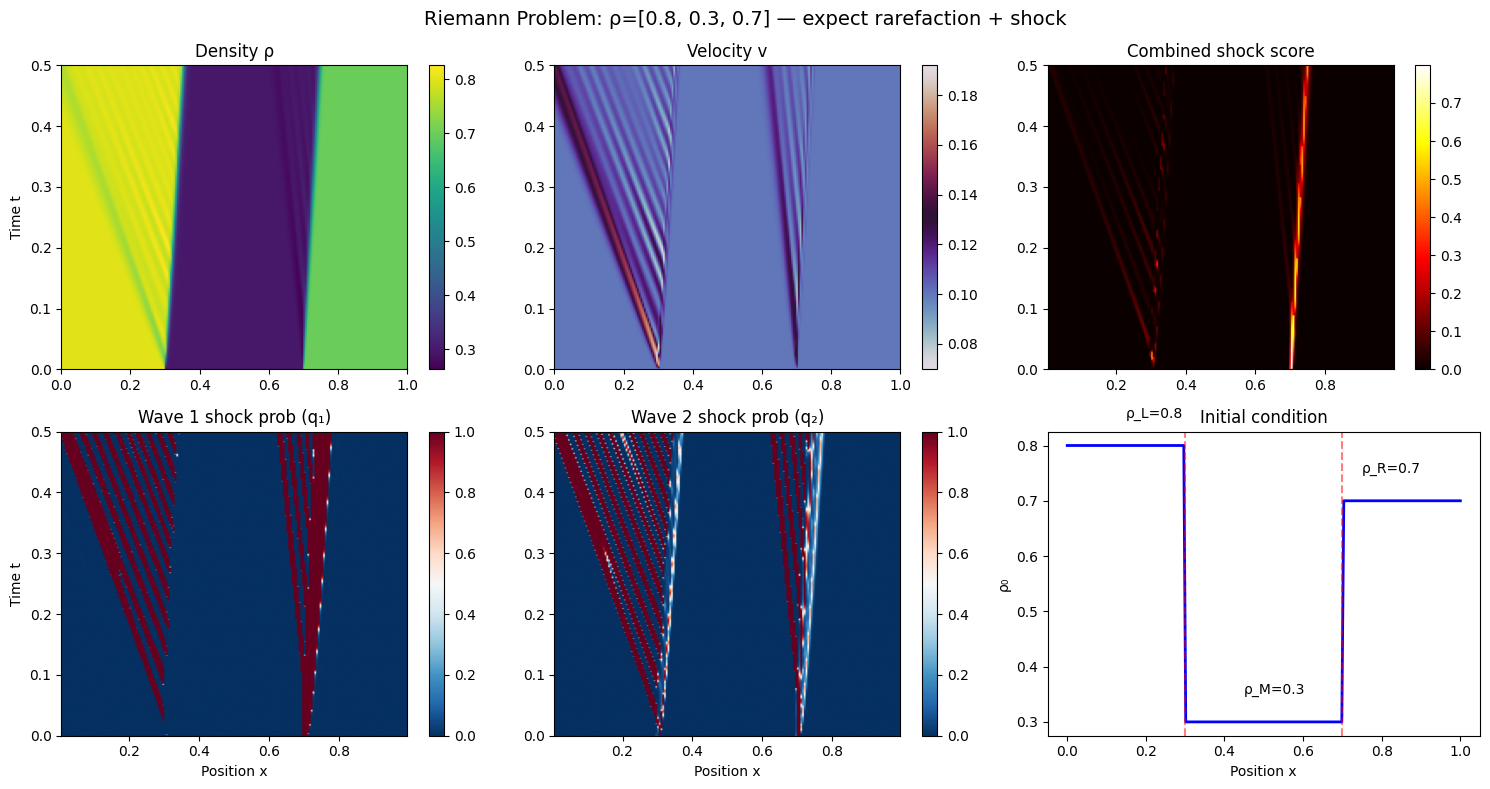


Initial condition: ρ_L=0.8 → ρ_M=0.3 → ρ_R=0.7
Left discontinuity (high→low): should produce rarefaction (q≈0)
Right discontinuity (low→high): should produce shock (q≈1)


In [12]:
print("Testing on Riemann problem with rarefaction + shock...")

config_riemann = ARZConfig(nx=200, T=0.5, gamma=gamma)

rho_L, rho_M, rho_R = 0.8, 0.3, 0.7
x_disc1, x_disc2 = 0.3, 0.7
rho0, w0 = initial_condition_from_steps(
    config_riemann.x, 
    [(x_disc1, rho_L), (x_disc2, rho_M), (1.1, rho_R)], 
    default_v=0.1, 
    gamma=gamma
)

rho_hist, w_hist, v_hist = run(rho0, w0, config_riemann, reconstruction=RECONSTRUCTION)

nt, nx_grid = rho_hist.shape
shock_map = np.zeros((nt, nx_grid - 2))
q_wave1 = np.zeros((nt, nx_grid - 2))
q_wave2 = np.zeros((nt, nx_grid - 2))

model.eval()
with torch.no_grad():
    for t_idx in range(nt):
        rho, w = rho_hist[t_idx], w_hist[t_idx]
        U_L_t = torch.tensor([[rho[i-1], rho[i-1]*w[i-1]] for i in range(1, nx_grid-1)], dtype=torch.float32).to(device)
        U_c_t = torch.tensor([[rho[i], rho[i]*w[i]] for i in range(1, nx_grid-1)], dtype=torch.float32).to(device)
        U_R_t = torch.tensor([[rho[i+1], rho[i+1]*w[i+1]] for i in range(1, nx_grid-1)], dtype=torch.float32).to(device)
        
        pred = model(U_L_t, U_c_t, U_R_t)
        s = compute_filtered_shock_score(pred, U_L_t, U_R_t, gamma)
        shock_map[t_idx] = s.cpu().numpy()
        q_wave1[t_idx] = pred["q"][:, 0].cpu().numpy()
        q_wave2[t_idx] = pred["q"][:, 1].cpu().numpy()

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
extent = [config_riemann.x[1], config_riemann.x[-2], 0, config_riemann.T]
extent_full = [config_riemann.x[0], config_riemann.x[-1], 0, config_riemann.T]

axes[0, 0].imshow(rho_hist, aspect="auto", origin="lower", extent=extent_full, cmap="viridis")
axes[0, 0].set_title("Density ρ")
axes[0, 0].set_ylabel("Time t")
plt.colorbar(axes[0, 0].images[0], ax=axes[0, 0])

axes[0, 1].imshow(v_hist, aspect="auto", origin="lower", extent=extent_full, cmap="twilight")
axes[0, 1].set_title("Velocity v")
plt.colorbar(axes[0, 1].images[0], ax=axes[0, 1])

axes[0, 2].imshow(shock_map, aspect="auto", origin="lower", extent=extent, cmap="hot")
axes[0, 2].set_title("Combined shock score")
plt.colorbar(axes[0, 2].images[0], ax=axes[0, 2])

axes[1, 0].imshow(q_wave1, aspect="auto", origin="lower", extent=extent, cmap="RdBu_r", vmin=0, vmax=1)
axes[1, 0].set_title("Wave 1 shock prob (q₁)")
axes[1, 0].set_ylabel("Time t")
axes[1, 0].set_xlabel("Position x")
plt.colorbar(axes[1, 0].images[0], ax=axes[1, 0])

axes[1, 1].imshow(q_wave2, aspect="auto", origin="lower", extent=extent, cmap="RdBu_r", vmin=0, vmax=1)
axes[1, 1].set_title("Wave 2 shock prob (q₂)")
axes[1, 1].set_xlabel("Position x")
plt.colorbar(axes[1, 1].images[0], ax=axes[1, 1])

axes[1, 2].plot(config_riemann.x, rho0, 'b-', linewidth=2)
axes[1, 2].set_title("Initial condition")
axes[1, 2].set_xlabel("Position x")
axes[1, 2].set_ylabel("ρ₀")
axes[1, 2].axvline(x_disc1, color='r', linestyle='--', alpha=0.5)
axes[1, 2].axvline(x_disc2, color='r', linestyle='--', alpha=0.5)
axes[1, 2].text(0.15, 0.85, f"ρ_L={rho_L}", fontsize=10)
axes[1, 2].text(0.45, 0.35, f"ρ_M={rho_M}", fontsize=10)
axes[1, 2].text(0.75, 0.75, f"ρ_R={rho_R}", fontsize=10)

plt.suptitle(f"Riemann Problem: ρ=[{rho_L}, {rho_M}, {rho_R}] — expect rarefaction + shock", fontsize=14)
plt.tight_layout()
plt.show()

print(f"\nInitial condition: ρ_L={rho_L} → ρ_M={rho_M} → ρ_R={rho_R}")
print("Left discontinuity (high→low): should produce rarefaction (q≈0)")
print("Right discontinuity (low→high): should produce shock (q≈1)")

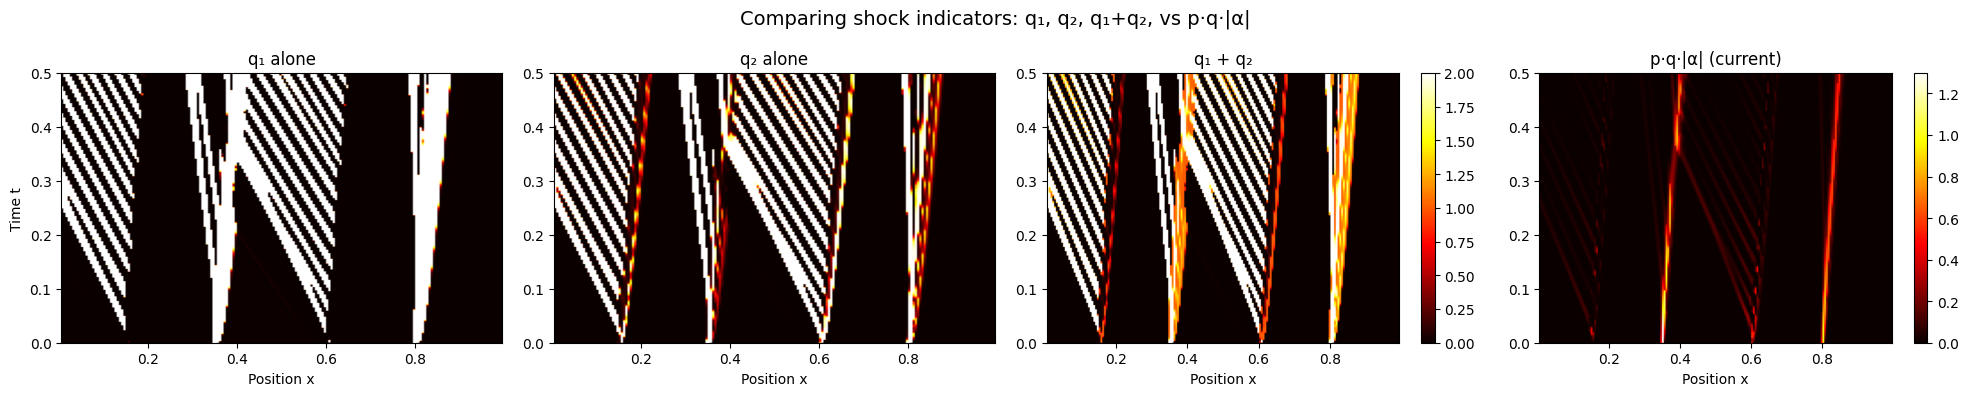

In [13]:
config_add = ARZConfig(nx=200, T=0.5, gamma=gamma)
rho_vals = [0.8, 0.3, 0.9, 0.2, 0.7]
x_discs = [0.15, 0.35, 0.6, 0.8]
rho_steps = list(zip(x_discs, rho_vals[:-1])) + [(1.1, rho_vals[-1])]
rho0, w0 = initial_condition_from_steps(config_add.x, rho_steps, default_v=0.1, gamma=gamma)
rho_hist, w_hist, v_hist = run(rho0, w0, config_add, reconstruction=RECONSTRUCTION)

nt, nx_grid = rho_hist.shape
q1_map = np.zeros((nt, nx_grid - 2))
q2_map = np.zeros((nt, nx_grid - 2))
shock_map = np.zeros((nt, nx_grid - 2))

model.eval()
with torch.no_grad():
    for t_idx in range(nt):
        rho, w = rho_hist[t_idx], w_hist[t_idx]
        U_L_t = torch.tensor([[rho[i-1], rho[i-1]*w[i-1]] for i in range(1, nx_grid-1)], dtype=torch.float32).to(device)
        U_c_t = torch.tensor([[rho[i], rho[i]*w[i]] for i in range(1, nx_grid-1)], dtype=torch.float32).to(device)
        U_R_t = torch.tensor([[rho[i+1], rho[i+1]*w[i+1]] for i in range(1, nx_grid-1)], dtype=torch.float32).to(device)
        pred = model(U_L_t, U_c_t, U_R_t)
        q1_map[t_idx] = pred["q"][:, 0].cpu().numpy()
        q2_map[t_idx] = pred["q"][:, 1].cpu().numpy()
        shock_map[t_idx] = compute_filtered_shock_score(pred, U_L_t, U_R_t, gamma).cpu().numpy()

q_sum = q1_map + q2_map

fig, axes = plt.subplots(1, 4, figsize=(20, 4))
extent = [config_add.x[1], config_add.x[-2], 0, config_add.T]

axes[0].imshow(q1_map, aspect="auto", origin="lower", extent=extent, cmap="hot", vmin=0, vmax=1)
axes[0].set_title("q₁ alone")
axes[0].set_ylabel("Time t")

axes[1].imshow(q2_map, aspect="auto", origin="lower", extent=extent, cmap="hot", vmin=0, vmax=1)
axes[1].set_title("q₂ alone")

axes[2].imshow(q_sum, aspect="auto", origin="lower", extent=extent, cmap="hot", vmin=0, vmax=2)
axes[2].set_title("q₁ + q₂")
plt.colorbar(axes[2].images[0], ax=axes[2])

axes[3].imshow(shock_map, aspect="auto", origin="lower", extent=extent, cmap="hot")
axes[3].set_title("p·q·|α| (current)")
plt.colorbar(axes[3].images[0], ax=axes[3])

for ax in axes:
    ax.set_xlabel("Position x")

plt.suptitle("Comparing shock indicators: q₁, q₂, q₁+q₂, vs p·q·|α|", fontsize=14)
plt.tight_layout()
plt.show()

Testing on multiple wave interactions...
Expected wave types:
  x=0.15: 0.8→0.3 (rarefaction)
  x=0.35: 0.3→0.9 (shock)
  x=0.6: 0.9→0.2 (rarefaction)
  x=0.8: 0.2→0.7 (shock)


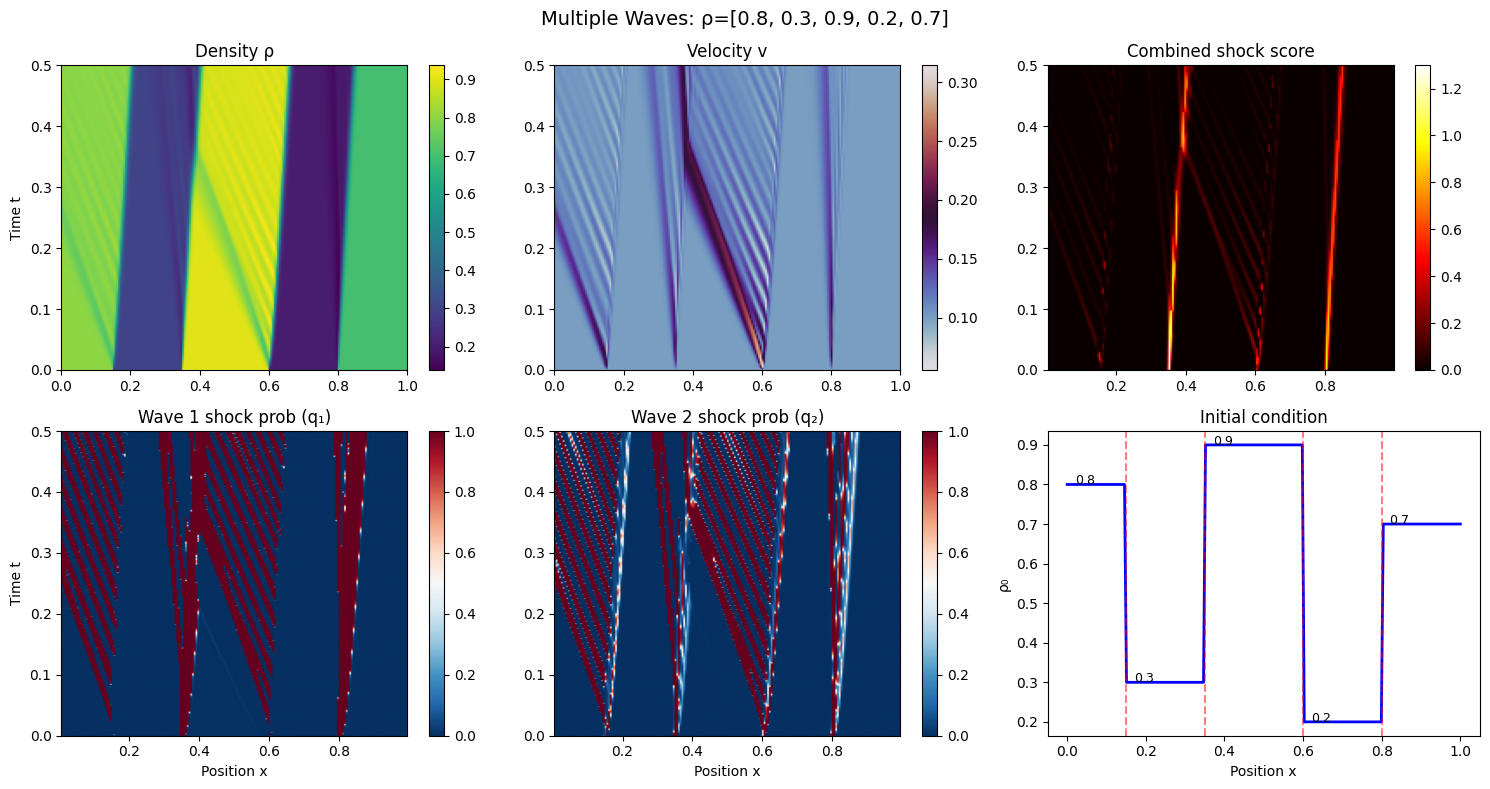

In [16]:
print("Testing on multiple wave interactions...")

config_multi = ARZConfig(nx=200, T=0.5, gamma=gamma)

rho_vals = [0.8, 0.3, 0.9, 0.2, 0.7]
x_discs = [0.15, 0.35, 0.6, 0.8]
rho_steps = list(zip(x_discs, rho_vals[:-1])) + [(1.1, rho_vals[-1])]
rho0, w0 = initial_condition_from_steps(config_multi.x, rho_steps, default_v=0.1, gamma=gamma)

rho_hist, w_hist, v_hist = run(rho0, w0, config_multi, reconstruction=RECONSTRUCTION)

nt, nx_grid = rho_hist.shape
shock_map = np.zeros((nt, nx_grid - 2))
q_wave1 = np.zeros((nt, nx_grid - 2))
q_wave2 = np.zeros((nt, nx_grid - 2))

model.eval()
with torch.no_grad():
    for t_idx in range(nt):
        rho, w = rho_hist[t_idx], w_hist[t_idx]
        U_L_t = torch.tensor([[rho[i-1], rho[i-1]*w[i-1]] for i in range(1, nx_grid-1)], dtype=torch.float32).to(device)
        U_c_t = torch.tensor([[rho[i], rho[i]*w[i]] for i in range(1, nx_grid-1)], dtype=torch.float32).to(device)
        U_R_t = torch.tensor([[rho[i+1], rho[i+1]*w[i+1]] for i in range(1, nx_grid-1)], dtype=torch.float32).to(device)
        
        pred = model(U_L_t, U_c_t, U_R_t)
        s = compute_filtered_shock_score(pred, U_L_t, U_R_t, gamma)
        shock_map[t_idx] = s.cpu().numpy()
        q_wave1[t_idx] = pred["q"][:, 0].cpu().numpy()
        q_wave2[t_idx] = pred["q"][:, 1].cpu().numpy()

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
extent = [config_multi.x[1], config_multi.x[-2], 0, config_multi.T]
extent_full = [config_multi.x[0], config_multi.x[-1], 0, config_multi.T]

axes[0, 0].imshow(rho_hist, aspect="auto", origin="lower", extent=extent_full, cmap="viridis")
axes[0, 0].set_title("Density ρ")
axes[0, 0].set_ylabel("Time t")
plt.colorbar(axes[0, 0].images[0], ax=axes[0, 0])

axes[0, 1].imshow(v_hist, aspect="auto", origin="lower", extent=extent_full, cmap="twilight")
axes[0, 1].set_title("Velocity v")
plt.colorbar(axes[0, 1].images[0], ax=axes[0, 1])

axes[0, 2].imshow(shock_map, aspect="auto", origin="lower", extent=extent, cmap="hot")
axes[0, 2].set_title("Combined shock score")
plt.colorbar(axes[0, 2].images[0], ax=axes[0, 2])

axes[1, 0].imshow(q_wave1, aspect="auto", origin="lower", extent=extent, cmap="RdBu_r", vmin=0, vmax=1)
axes[1, 0].set_title("Wave 1 shock prob (q₁)")
axes[1, 0].set_ylabel("Time t")
axes[1, 0].set_xlabel("Position x")
plt.colorbar(axes[1, 0].images[0], ax=axes[1, 0])

axes[1, 1].imshow(q_wave2, aspect="auto", origin="lower", extent=extent, cmap="RdBu_r", vmin=0, vmax=1)
axes[1, 1].set_title("Wave 2 shock prob (q₂)")
axes[1, 1].set_xlabel("Position x")
plt.colorbar(axes[1, 1].images[0], ax=axes[1, 1])

axes[1, 2].plot(config_multi.x, rho0, 'b-', linewidth=2)
axes[1, 2].set_title("Initial condition")
axes[1, 2].set_xlabel("Position x")
axes[1, 2].set_ylabel("ρ₀")
for xd in x_discs:
    axes[1, 2].axvline(xd, color='r', linestyle='--', alpha=0.5)
for i, (xd, rv) in enumerate(zip([0] + x_discs, rho_vals)):
    axes[1, 2].text(xd + 0.02, rv, f"{rv}", fontsize=9)

labels = []
for i in range(len(rho_vals) - 1):
    kind = "shock" if rho_vals[i] < rho_vals[i+1] else "rarefaction"
    labels.append(f"x={x_discs[i]}: {rho_vals[i]}→{rho_vals[i+1]} ({kind})")
print("Expected wave types:")
for l in labels:
    print(f"  {l}")

plt.suptitle(f"Multiple Waves: ρ={rho_vals}", fontsize=14)
plt.tight_layout()
plt.show()

Testing on complex initial conditions...


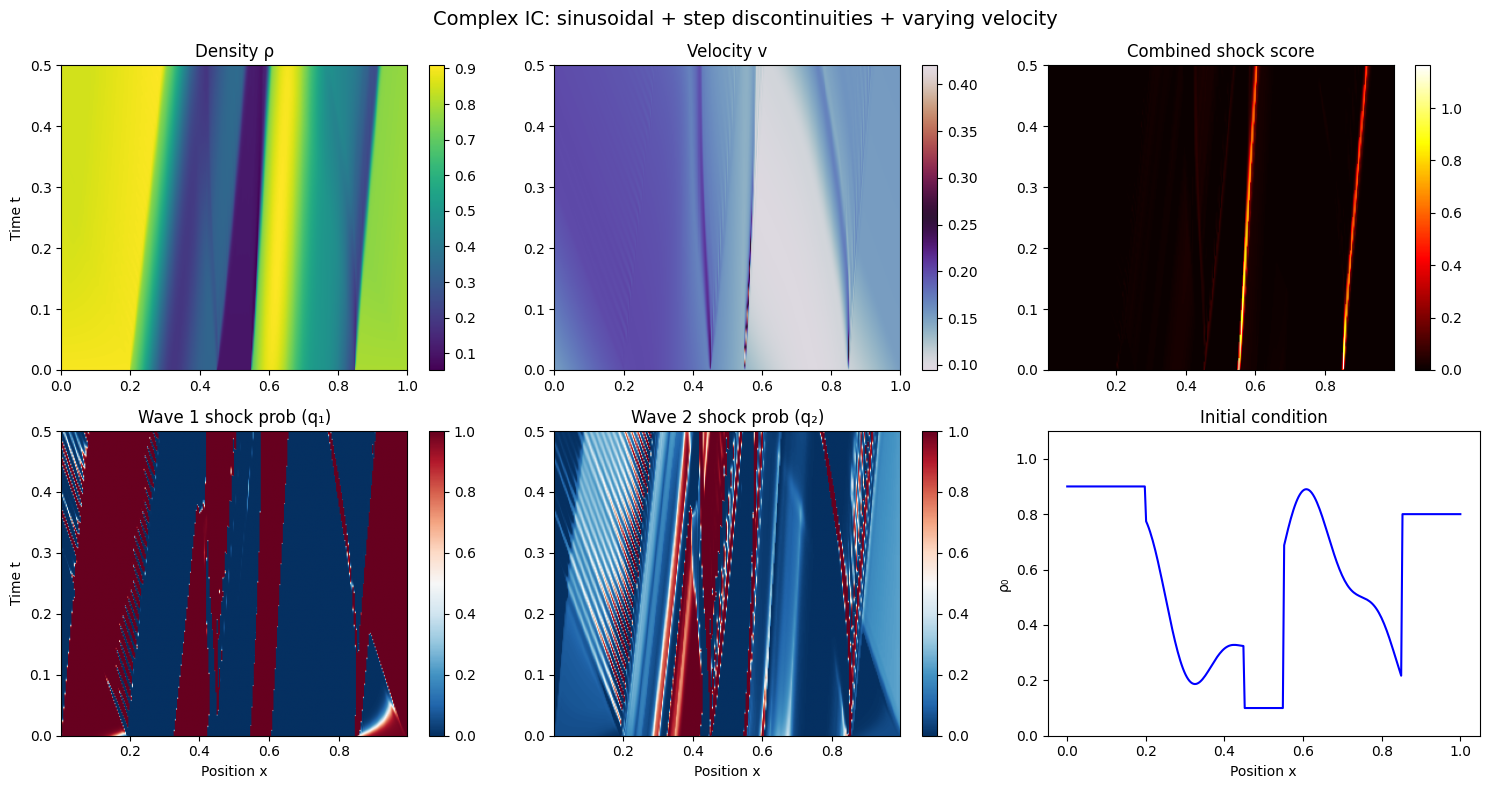

In [17]:
print("Testing on complex initial conditions...")

config_complex = ARZConfig(nx=300, T=0.5, gamma=gamma)
x = config_complex.x

rho0 = 0.5 + 0.3 * np.sin(4 * np.pi * x) + 0.1 * np.cos(10 * np.pi * x)
rho0 = np.clip(rho0, 0.05, 1.0)
rho0[x < 0.2] = 0.9
rho0[(x > 0.45) & (x < 0.55)] = 0.1
rho0[x > 0.85] = 0.8

v0 = 0.15 + 0.05 * np.sin(2 * np.pi * x)
w0 = v0 + rho0 ** gamma

rho_hist, w_hist, v_hist = run(rho0, w0, config_complex, reconstruction=RECONSTRUCTION)

nt, nx_grid = rho_hist.shape
shock_map = np.zeros((nt, nx_grid - 2))
q_wave1 = np.zeros((nt, nx_grid - 2))
q_wave2 = np.zeros((nt, nx_grid - 2))

model.eval()
with torch.no_grad():
    for t_idx in range(nt):
        rho, w = rho_hist[t_idx], w_hist[t_idx]
        U_L_t = torch.tensor([[rho[i-1], rho[i-1]*w[i-1]] for i in range(1, nx_grid-1)], dtype=torch.float32).to(device)
        U_c_t = torch.tensor([[rho[i], rho[i]*w[i]] for i in range(1, nx_grid-1)], dtype=torch.float32).to(device)
        U_R_t = torch.tensor([[rho[i+1], rho[i+1]*w[i+1]] for i in range(1, nx_grid-1)], dtype=torch.float32).to(device)
        
        pred = model(U_L_t, U_c_t, U_R_t)
        s = compute_filtered_shock_score(pred, U_L_t, U_R_t, gamma)
        shock_map[t_idx] = s.cpu().numpy()
        q_wave1[t_idx] = pred["q"][:, 0].cpu().numpy()
        q_wave2[t_idx] = pred["q"][:, 1].cpu().numpy()

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
extent = [x[1], x[-2], 0, config_complex.T]
extent_full = [x[0], x[-1], 0, config_complex.T]

axes[0, 0].imshow(rho_hist, aspect="auto", origin="lower", extent=extent_full, cmap="viridis")
axes[0, 0].set_title("Density ρ")
axes[0, 0].set_ylabel("Time t")
plt.colorbar(axes[0, 0].images[0], ax=axes[0, 0])

axes[0, 1].imshow(v_hist, aspect="auto", origin="lower", extent=extent_full, cmap="twilight")
axes[0, 1].set_title("Velocity v")
plt.colorbar(axes[0, 1].images[0], ax=axes[0, 1])

axes[0, 2].imshow(shock_map, aspect="auto", origin="lower", extent=extent, cmap="hot")
axes[0, 2].set_title("Combined shock score")
plt.colorbar(axes[0, 2].images[0], ax=axes[0, 2])

axes[1, 0].imshow(q_wave1, aspect="auto", origin="lower", extent=extent, cmap="RdBu_r", vmin=0, vmax=1)
axes[1, 0].set_title("Wave 1 shock prob (q₁)")
axes[1, 0].set_ylabel("Time t")
axes[1, 0].set_xlabel("Position x")
plt.colorbar(axes[1, 0].images[0], ax=axes[1, 0])

axes[1, 1].imshow(q_wave2, aspect="auto", origin="lower", extent=extent, cmap="RdBu_r", vmin=0, vmax=1)
axes[1, 1].set_title("Wave 2 shock prob (q₂)")
axes[1, 1].set_xlabel("Position x")
plt.colorbar(axes[1, 1].images[0], ax=axes[1, 1])

axes[1, 2].plot(x, rho0, 'b-', linewidth=1.5)
axes[1, 2].set_title("Initial condition")
axes[1, 2].set_xlabel("Position x")
axes[1, 2].set_ylabel("ρ₀")
axes[1, 2].set_ylim(0, 1.1)

plt.suptitle("Complex IC: sinusoidal + step discontinuities + varying velocity", fontsize=14)
plt.tight_layout()
plt.show()